# Cloning a TelFit telluric model spectrum

One of `blasé`'s neat capabilities is to jointly model both the stellar spectrum and the telluric spectrum simultaneously.  Here we demonstate the telluric cloning step of that process---in isolation---as we move towards a goal of an end-to-end whole-spectrum fitting.

In [1]:
import torch
from blase.emulator import SparseLogEmulator
from gollum.telluric import TelFitSpectrum
import numpy as np
%config InlineBackend.figure_format='retina'

In [2]:
device = "cpu" # Change to "cuda" if you happen to have an NVIDIA GPU available.

#### Set the wavelength limits
Here we choose a small region to match the previous stellar spectrum demo.

In [3]:
wl_lo = 11_000-60
wl_hi = 11_180+60

## Read in a precomputed synthetic telluric spectrum

We start with a precomputed [TelFit](https://telfit.readthedocs.io/en/latest/) model.  TelFit is a Python wrapper to `lblrtm`, a tunable line-by-line radiative transfer model of Earth's atmospheric absorption, as a function of temperature, pressure, humidity, and the detailed molecular compositions of Earth's atmosphere's bulk and trace gases.  This SciPy 2015 video by Kevin Gullkison describes the code:

In [4]:
from IPython.display import IFrame
IFrame('https://www.youtube.com/embed/1_7F7ZBvF88', 560, 315)

This file was generated with `TelFit`, previously saved locally, uploaded to [Box](https://www.box.com), and made publicly available via a static link (which has the unfortunate side effect of obfuscating the original filename).  

The model was evaluated with a $60^{\circ}$ F nighttime temperature and 40% humidity with an altitude consistent with McDonald Observatory and an airmass set to the HET's fixed airmass.

Practitioners will likely want to regenerate a bespoke TelFit model that matches their atmospheric conditions and site.  The model need not arise from TelFit, and in principle [molecfit](https://www.eso.org/sci/software/pipelines/skytools/molecfit), or [Planetary Spectrum Generator](https://psg.gsfc.nasa.gov), or other model templates *should* work so long as they are noise-free ultra-high-resolution models.

In [5]:
#local_file = '/Volumes/pecos/libraries/raw/telfit/grid_v1p0/telfit_800_1300nm_temp290_hum040.txt'
web_link = 'https://utexas.box.com/shared/static/3d43yqog5htr93qbfql3acg4v4wzhbn8.txt'

In [6]:
telluric_spectrum_full = TelFitSpectrum(path=web_link).air_to_vacuum()

In [7]:
mask = ((telluric_spectrum_full.wavelength.value > wl_lo) & 
        (telluric_spectrum_full.wavelength.value < wl_hi) )
telluric_spectrum = telluric_spectrum_full.apply_boolean_mask(mask)

Great! Let's clone the telluric spectrum with the LogEmulator.

In [8]:
telluric_wl = telluric_spectrum.wavelength.value
telluric_flux = np.abs(telluric_spectrum.flux.value)
telluric_lnflux = np.log(telluric_flux) # "natural log" or log base `e`

Below about `-15` in `ln` space, the flux becomes dominated by **numerical artifacts**.  That's okay, we will never perceive flux that is less than a ten-millionth of the continuum, so we can simply chop it off.  

In [9]:
telluric_lnflux[telluric_lnflux < -15] = -15

The emulate takes in the spectrum and finds all the "prominent" spectral lines above some `prominence` threshold.  A prominence threshold of `0.01` roughly corresponds to absorption lines that are 1% below the continuum.  

We use a **logarithmic** emulator for telluric lines because some spectral lines are so saturated that they appear to have nearly flat bottoms asymptotically approaching `0.0`.  Linear emulators tend to break in this saturated regime.

In [10]:
%%capture
emulator = SparseLogEmulator(telluric_wl, telluric_lnflux, 
                             wing_cut_pixels=6000, prominence=0.01, device=device)

The coarse initialization of the emulator yields lousy clones, just like we saw in the stellar cloning example.  Nevertheless, let's spotcheck what the spectrum looks like:

In [11]:
with torch.no_grad():
    telluric_pre = emulator.forward().cpu().numpy()

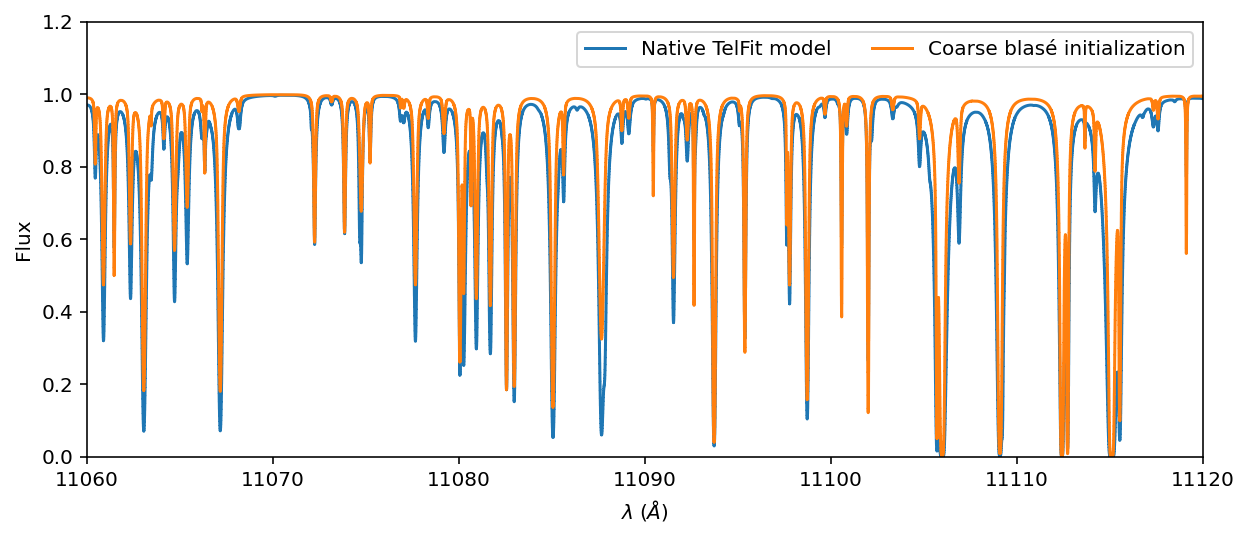

In [12]:
ax = telluric_spectrum.plot(ylo=0, yhi=1.2, label='Native TelFit model');
ax.step(telluric_wl, telluric_pre, label='Coarse blasé initialization')
ax.set_xlim(11_060, 11_120)
ax.legend(loc='upper right', ncol=2);

As we expected, the clone does not match the native resolution `TelFit` model.  We will *fine-tune* the cloned line properties to make the match nearly pixel-perfect.  That process is sometimes referred to as *optimization*.

## Fine-tuning the spectral line properties

One neat aspect of PyTorch is that it's easy to fix parameters in the optimization process. You simply turn off the gradients of some parameter.  Operationally, this simple switch makes it so that those `requires_grad = False` parameters cannot "sense" the direction to a better fit and so they simply stay where they are.   

Here we fill fix the *line center positions* $\lambda_0$, and vary the amplitude, width, and shape of each Voigt profile.

In [13]:
emulator.lam_centers.requires_grad = False
emulator.amplitudes.requires_grad = True
emulator.sigma_widths.requires_grad = True
emulator.gamma_widths.requires_grad = True

We choose 100 epochs and a learning rate `LR` of 0.05, favoring speed over precision.  We recommend training for more epochs with a finer learning rate if you are unsatisfied with the precision you obtain.

In [14]:
emulator.optimize(epochs=100, LR=0.05)

Training Loss: 0.00019175: 100%|██████████████| 100/100 [01:31<00:00,  1.09it/s]


Those 100 epochs took about 90 seconds on my M1 Macbook Air.  We can now examine the fine-tuned forward model.

In [15]:
with torch.no_grad():
    telluric_post = emulator.forward().cpu().numpy()

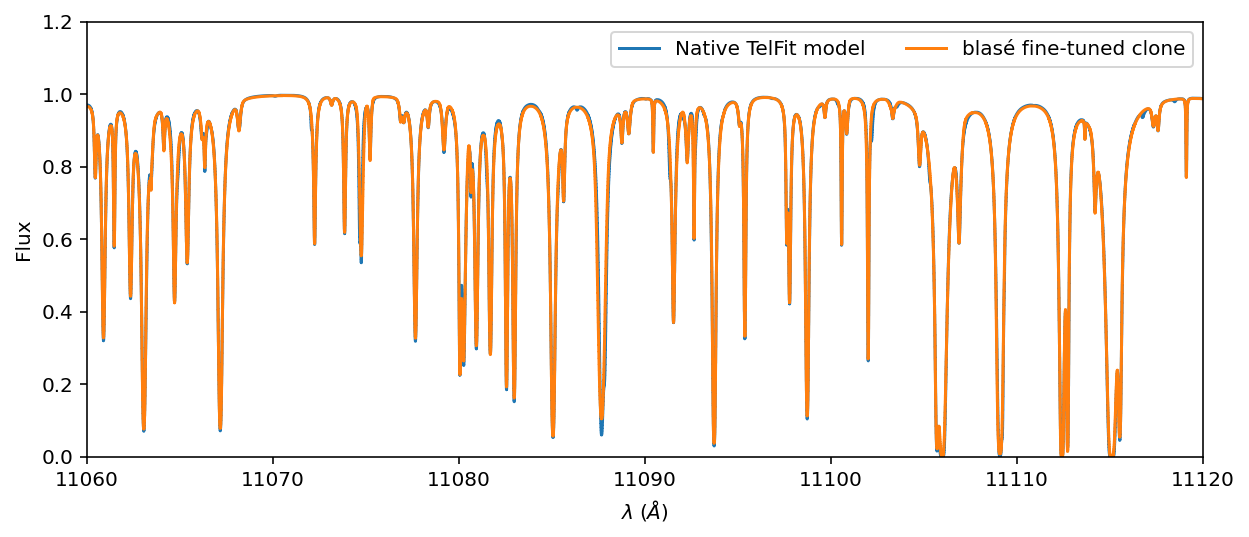

In [16]:
ax = telluric_spectrum.plot(ylo=0, yhi=1.2, label='Native TelFit model');
ax.step(telluric_wl, telluric_post, label='blasé fine-tuned clone')
ax.set_xlim(11_060, 11_120)
ax.legend(loc='upper right', ncol=2);

Nice! The cloning appears near pixel-perfect, with the exception of the line cores of a few lines.  Recall that this model will eventually get convolved with an instrumental kernel and resampled before being compared to data, and so these apparently conspicuous flaws will be significantly dilluted.  

Allowing the $\lambda_0$ to vary may also result in a slightly better clone, since flaws in the guessed line positions are baked in, and it is currently impossible for the clone to wiggle free of these overzealous restraints.  We encourage you to experiment with turning on `emulator.lam_centers.requires_grad = True` to see to what extent the clone improves.

In summary, we have "reverse-engineered" the TelFit model to get a flexible and interpretable clone that we can then transfer to a semi-empirical model later on.  